In [66]:
import gspread as gs
import pandas as pd
import json
import matplotlib.pyplot as plt

In [5]:
gc = gs.service_account(filename='google_forms_service_account.json')
url = "https://docs.google.com/spreadsheets/d/13bp-6oVE_KvA9XSeNkV3Nbk6jX-zDTYYlbnTxIaunv8/edit?resourcekey#gid=2040687576"
sh = gc.open_by_url(url)
ws = sh.worksheet('responses')

In [118]:
df = pd.DataFrame(ws.get_all_records())
df.head()

,Timestamp,Data
0,9/28/2022 19:26:27,"{""playerName"" : ""player1"",""level"" : 1,""playerD..."
1,9/28/2022 19:26:38,"{""playerName"" : ""player1"",""level"" : 1,""playerD..."
2,9/28/2022 19:26:50,"{""playerName"" : ""player1"",""level"" : 1,""playerD..."
3,9/28/2022 19:26:58,"{""playerName"" : ""player1"",""level"" : 2,""playerD..."
4,9/28/2022 19:27:19,"{""playerName"" : ""player1"",""level"" : 2,""playerD..."


In [119]:
data = []

for row in df['Data']:
    res = json.loads(row)
    data.append(res)
    
df1 = pd.DataFrame.from_dict(data)
df1

,playerName,level,playerDeaths,cloneDeaths
0,player1,1,0,0
1,player1,1,1,1
2,player1,1,2,2
3,player1,2,0,0
4,player1,2,1,1
5,player1,2,2,2
6,player1,1,2,5


# Average Player Deaths per Level

<AxesSubplot: ylabel='level'>

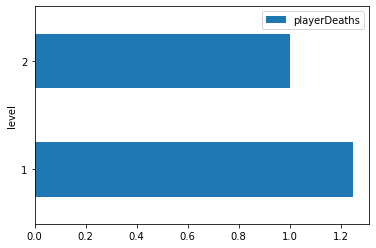

In [120]:
# Average player deaths per level
playerDeathsAvgLevel=df1.groupby(by=["level"]).aggregate({"playerDeaths":"mean"})
playerDeathsAvgLeveldf = playerDeathsAvgLevel.reset_index()

playerDeathsAvgLeveldf.plot(x = 'level', y = 'playerDeaths', kind = 'barh')

# Average Clone Deaths per Level

<AxesSubplot: ylabel='level'>

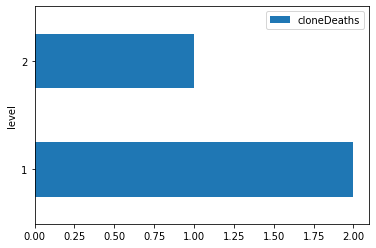

In [121]:
# Average player deaths per level
cloneDeathsAvgLevel=df1.groupby(by=["level"]).aggregate({"cloneDeaths":"mean"})
cloneDeathsAvgLeveldf = cloneDeathsAvgLevel.reset_index()

cloneDeathsAvgLeveldf.plot(x = 'level', y = 'cloneDeaths', kind = 'barh')

# Average Player and Clone Deaths per Level

<AxesSubplot: xlabel='level'>

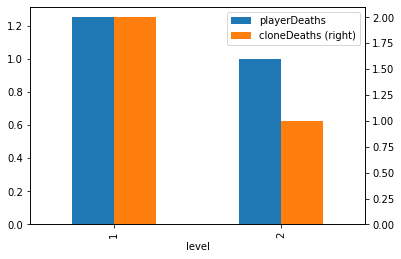

In [122]:
# Average player and deaths per level
deathsAvgLevel=df1.groupby(by=["level"]).aggregate({"playerDeaths":"mean", "cloneDeaths":"mean"})
deathsAvgLeveldf = deathsAvgLevel.reset_index()

# deathsAvgLeveldf.plot(x = 'level', y = 'playerDeaths', kind = 'barh')
deathsAvgLeveldf.plot(x = 'level', secondary_y = 'cloneDeaths', kind = 'bar')